In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
  ## The raw code was developed on Colab and Drive data

## In this project, we would not use stacking
## In contrast, we could use LR, Logistic and DNN

## Workflow
## Use biological features as exposure, chronological age (CA) as outcome to train models
## The model should be minimize the MSE of predicted age and true CA

## Comparision
## Compared the MSE,RMSE in the test dataset and see which model is the best

## Test the performance of predicting all-cause mortality
## Check whether BA/accelerated BA could predict mortality independent of CA

## Got the distribution of BA among different age groups
## And develop app to help subjects understand their BA status.
## Visualization
  ## Histograms for different age, percentils and risk of mortality

Mounted at /content/drive


In [ ]:
## Load Packages
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK

## Packages for modeling training
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [4]:
## Check data path
current_path = os.getcwd()
print(os.listdir(current_path))

['.DS_Store', 'capstone_workflow.ipynb', 'capstone_stream_app.py', 'results', 'data']


## Preprocess Data

### Read & Clean

In [6]:
## Read Data
df = pd.read_stata('data/merged_analysis_2015_2018.dta')
df = df[df['age'].notnull()] # exclude subjects with missing age
df = df[(df['age'] >= 45) & (df['age'] <= 90)]  # limit age between 45 and 90

## Extract variables used for training models
df_biomarker = pd.concat([df.iloc[:,1:16], df.iloc[:,19:22], df.iloc[:,25]], axis = 1)
df_age = df['age']

## show missing patterns
import seaborn as sns
# sns.heatmap(df_biomarker.isnull(), cbar=False, yticklabels=False)
# plt.title("Missing Values Heatmap")
# plt.show()

## Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(df_biomarker)
df_biomarker = pd.DataFrame(imputer.transform(df_biomarker),
                            columns=df_biomarker.columns)

# df_biomarker.isnull().sum()

In [7]:
# Define x and y data set
df_x = df_biomarker
df_y = df_age

# Standardize X dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_x = pd.DataFrame(
    scaler.fit_transform(df_x),
    columns=df_x.columns,
    index=df_x.index
)

## Partition Training and Test dataset
x_train, x_test, y_train, y_test = train_test_split(
    df_x, df_y,
    test_size = 0.2,
    random_state=1234)
x_trainset, x_validset, y_trainset, y_validset = train_test_split(
    x_train, y_train,
    test_size = 0.2,
    random_state=1234)

### Define Functions

In [8]:
# Define general functions
def result(dataset, predict_dataset):
    R2 = r2_score(dataset, predict_dataset)
    RMSE = sqrt(mean_squared_error(dataset, predict_dataset))
    MAE = mean_absolute_error(dataset, predict_dataset)
    return R2, RMSE, MAE

def model_results(model):
    predict_train = model.predict(x_trainset)
    predict_valid = model.predict(x_validset)

    R2_train, RMSE_train, MAE_train = result(y_trainset, predict_train)
    R2_valid, RMSE_valid, MAE_valid = result(y_validset, predict_valid)

    plt.scatter(y_validset, predict_valid)

    result_list = pd.DataFrame()
    result_list['train_RMSE'] = []
    result_list['train_R2'] = []
    result_list['train_MAE'] = []
    result_list['valid_RMSE'] = []
    result_list['valid_R2'] = []
    result_list['valid_MAE'] = []

    result_list.loc[0] = [RMSE_train, R2_train, MAE_train, RMSE_valid, R2_valid, MAE_valid]
    print(result_list)
    return result_list

def model_final_results(model):
    predict_train = model.predict(x_train)
    predict_test = model.predict(x_test)

    R2_train, RMSE_train, MAE_train = result(y_train, predict_train)
    R2_test, RMSE_test, MAE_test = result(y_test, predict_test)

    plt.scatter(y_test, predict_test)

    result_list = pd.DataFrame()
    result_list['train_RMSE'] = []
    result_list['train_R2'] = []
    result_list['train_MAE'] = []
    result_list['test_RMSE'] = []
    result_list['test_R2'] = []
    result_list['test_MAE'] = []

    result_list.loc[0] = [RMSE_train, R2_train, MAE_train, RMSE_test, R2_test, MAE_test]

    print(result_list)
    return result_list

def importance_results(model):
    features = x_trainset.columns
    importances = model.feature_importances_
    importance_df = pd.DataFrame()
    importance_df['Feature Name'] = features
    importance_df['Feature Importance'] = importances
    importance_temp = importance_df.sort_values('Feature Importance', ascending=False)
    return importance_temp


## Train candidate models

### AdaBoost

In [15]:
random.seed(1234)
## Searching Space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
}

# Objectice functions (RMSE)
def hyperparameter_tuning(params: dict) -> dict:
    n_estimators = int(params['n_estimators'])  # change into integer
    learning_rate = params['learning_rate']

    model = AdaBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=123
    )

    model.fit(x_trainset, y_trainset)
    preds = model.predict(x_validset)
    rmse = sqrt(mean_squared_error(y_validset, preds))

    print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate:.4f} --> RMSE: {rmse:.4f}")

    return {'loss': rmse, 'status': STATUS_OK, 'model': model}

# Optimize parameters
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(123)
)

print("Best hyperparameters:", {
    'n_estimators': int(best['n_estimators']),
    'learning_rate': best['learning_rate']
})

n_estimators: 300, learning_rate: 0.0626 --> RMSE: 8.8700
n_estimators: 550, learning_rate: 0.1458 --> RMSE: 8.8712                      
n_estimators: 100, learning_rate: 0.8864 --> RMSE: 8.9006                      
n_estimators: 600, learning_rate: 0.0440 --> RMSE: 8.8873                      
n_estimators: 150, learning_rate: 0.4683 --> RMSE: 8.9267                      
n_estimators: 1000, learning_rate: 0.1387 --> RMSE: 8.8725                     
n_estimators: 150, learning_rate: 0.1603 --> RMSE: 8.8863                      
n_estimators: 700, learning_rate: 0.9944 --> RMSE: 8.9688                      
n_estimators: 900, learning_rate: 0.7678 --> RMSE: 8.9070                      
n_estimators: 750, learning_rate: 0.3843 --> RMSE: 8.8611                      
n_estimators: 600, learning_rate: 0.6148 --> RMSE: 8.9247                       
n_estimators: 800, learning_rate: 0.3476 --> RMSE: 8.9168                       
n_estimators: 750, learning_rate: 0.1737 --> RMSE: 8.8918   

### XGBoost

In [16]:
random.seed(1234)
## Searching Space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
}

# Objectice functions (RMSE)
def hyperparameter_tuning(params: dict) -> dict:
    model = XGBRegressor(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        gamma=params['gamma'],
        reg_alpha=int(params['reg_alpha']),
        reg_lambda=params['reg_lambda'],
        colsample_bytree=params['colsample_bytree'],
        min_child_weight=int(params['min_child_weight']),
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=123,
        verbosity=0
    )

    model.fit(
        x_trainset, y_trainset,
        eval_set=[(x_validset, y_validset)],
        verbose=False
    )

    preds = model.predict(x_validset)
    rmse = sqrt(mean_squared_error(y_validset, preds))

    print(f"[Trial] n_estimators={int(params['n_estimators'])}, "
          f"max_depth={int(params['max_depth'])}, "
          f"gamma={params['gamma']:.3f}, "
          f"reg_alpha={int(params['reg_alpha'])}, "
          f"reg_lambda={params['reg_lambda']:.3f}, "
          f"colsample_bytree={params['colsample_bytree']:.3f}, "
          f"min_child_weight={int(params['min_child_weight'])}, "
          f"learning_rate={params['learning_rate']:.3f} --> RMSE: {rmse:.4f}")

    return {'loss': rmse, 'status': STATUS_OK, 'model': model}

# Optimize parameters
trials = Trials()
best = fmin(
    fn=hyperparameter_tuning,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate=np.random.default_rng(123)
)

# Export best parameter set
print("Best hyperparameters:")
for k, v in best.items():
    if k in ['n_estimators', 'max_depth', 'reg_alpha', 'min_child_weight']:
        print(f"{k}: {int(v)}")
    else:
        print(f"{k}: {round(v, 4)}")

[Trial] n_estimators=350, max_depth=3, gamma=8.906, reg_alpha=47, reg_lambda=0.249, colsample_bytree=0.981, min_child_weight=7, learning_rate=0.464 --> RMSE: 8.2667
[Trial] n_estimators=1000, max_depth=9, gamma=4.243, reg_alpha=59, reg_lambda=0.496, colsample_bytree=0.872, min_child_weight=0, learning_rate=0.215 --> RMSE: 8.2170
[Trial] n_estimators=500, max_depth=6, gamma=8.796, reg_alpha=164, reg_lambda=0.006, colsample_bytree=0.924, min_child_weight=6, learning_rate=0.241 --> RMSE: 8.0685
[Trial] n_estimators=500, max_depth=4, gamma=5.082, reg_alpha=45, reg_lambda=0.583, colsample_bytree=0.741, min_child_weight=8, learning_rate=0.163 --> RMSE: 8.0766
[Trial] n_estimators=1000, max_depth=9, gamma=7.401, reg_alpha=105, reg_lambda=0.048, colsample_bytree=0.511, min_child_weight=6, learning_rate=0.126 --> RMSE: 8.1670
[Trial] n_estimators=750, max_depth=8, gamma=8.308, reg_alpha=58, reg_lambda=0.976, colsample_bytree=0.887, min_child_weight=0, learning_rate=0.178 --> RMSE: 8.1992
[Trial

### MLR

In [18]:
from sklearn.linear_model import LinearRegression

# train MLR model
md_mlr = LinearRegression()
md_mlr.fit(x_train, y_train)

y_pred = md_mlr.predict(x_validset)
y_true = y_validset

# calculate RMSE
print("RMSE:", sqrt(mean_squared_error(y_true, y_pred)))

RMSE: 9.150286610601459


### NN

In [17]:
random.seed(1234)
import torch
from torch.utils.data import TensorDataset, DataLoader

# Change data into tensor
X_train_tensor = torch.tensor(x_trainset.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_trainset.values, dtype=torch.float32).view(-1, 1)
X_valid_tensor = torch.tensor(x_validset.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_validset.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

## Define NN framework
import torch.nn as nn
class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


## Train models
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

md_nn = RegressionNN(input_dim=X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(md_nn.parameters(), lr=0.001)

## Training Process
for epoch in range(150):
    md_nn.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = md_nn(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation Set RMSE
    md_nn.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb = xb.to(device)
            pred = md_nn(xb).cpu()
            preds.append(pred)
            actuals.append(yb)

    preds = torch.cat(preds).numpy()
    actuals = torch.cat(actuals).numpy()
    rmse = sqrt(mean_squared_error(actuals, preds))

    if epoch % 20 == 19:
      print(f"Epoch {epoch+1} - RMSE: {rmse:.4f}")

Epoch 20 - RMSE: 8.7885
Epoch 40 - RMSE: 8.4232
Epoch 60 - RMSE: 8.2710
Epoch 80 - RMSE: 8.1282
Epoch 100 - RMSE: 8.0802
Epoch 120 - RMSE: 8.1403
Epoch 140 - RMSE: 8.1068


## Compare Model Performances

### Adaboost

   train_RMSE  train_R2  train_MAE  test_RMSE   test_R2  test_MAE
0    8.753798  0.159075   7.270022   8.686429  0.147693  7.192903


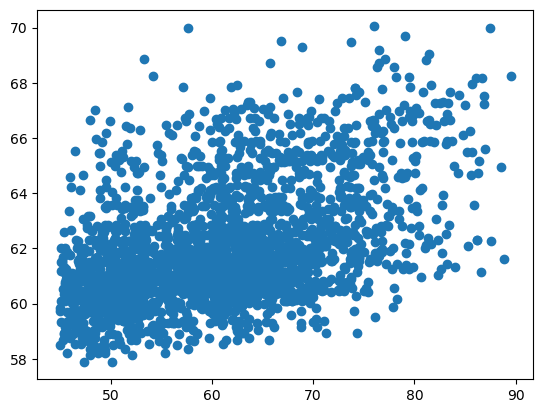

In [19]:
# AdaBoost model
md_ada = AdaBoostRegressor(n_estimators = 400,
                           learning_rate = 0.140)

md_ada.fit(x_train, y_train)
test_ada = model_final_results(md_ada)

### XGBoost

In [20]:
best

{'colsample_bytree': 0.6750138340086275,
 'gamma': 2.7676563739416506,
 'learning_rate': 0.19608351430689258,
 'max_depth': 4.0,
 'min_child_weight': 10.0,
 'n_estimators': 100.0,
 'reg_alpha': 161.0,
 'reg_lambda': 0.998483187162256}

   train_RMSE  train_R2  train_MAE  test_RMSE   test_R2  test_MAE
0     7.15574  0.438082   5.771918   7.620712  0.343999  6.220521


,Feature Name,Feature Importance
16,Weight,0.151415
3,Glycated_Hemoglobin,0.126134
8,Creatinine,0.113691
15,Waist,0.077034
11,BUN,0.067769
18,Gender,0.060419
2,Hemoglobin,0.052927
13,MCV,0.052810
4,CRP,0.037057
10,Triglycerides,0.033958


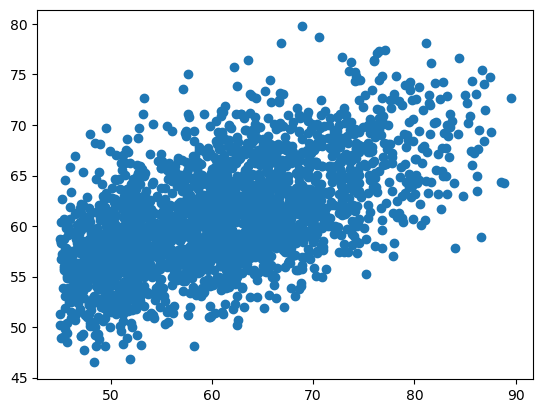

In [21]:
## Optimized Hyper-parameter
#  'colsample_bytree': 0.6750138340086275,
#  'gamma': 2.7676563739416506,
#  'learning_rate': 0.19608351430689258,
#  'max_depth': 4.0,
#  'min_child_weight': 10.0,
#  'n_estimators': 100.0,
#  'reg_alpha': 161.0,
#  'reg_lambda': 0.998483187162256

md_xgb = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    gamma=2.77,
    reg_alpha=161,
    reg_lambda=0.9985,
    colsample_bytree=0.675,
    min_child_weight=10,
    learning_rate=0.196,
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=123,
    verbosity=0
)


md_xgb.fit(x_train, y_train, verbose=False)
test_xgb = model_final_results(md_xgb)

importance_results(md_xgb)

### MLR

   train_RMSE  train_R2  train_MAE  test_RMSE   test_R2  test_MAE
0    9.021232  0.106909   7.385849   8.916694  0.101907  7.250108


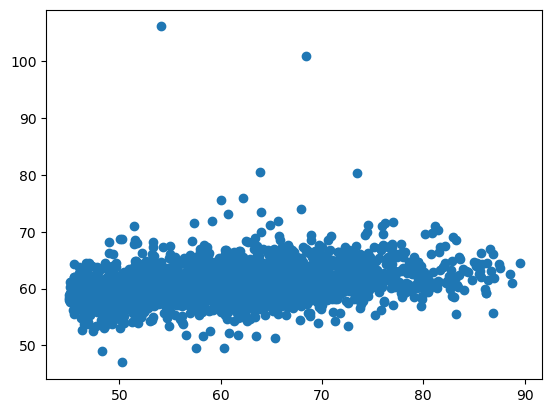

In [22]:
test_mlr = model_final_results(md_mlr)

### NN

In [23]:
X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

md_nn.eval()
with torch.no_grad():
    y_pred_test = md_nn(X_test_tensor)
    y_pred_train = md_nn(X_train_tensor)

## Validation Performance
y_train_np = y_train_tensor.cpu().numpy()
y_pred_train_np = y_pred_train.cpu().numpy()

RMSE_train = sqrt(mean_squared_error(y_train_np, y_pred_train_np))
R2_train = r2_score(y_train_np, y_pred_train_np)
MAE_train = mean_absolute_error(y_train_np, y_pred_train_np)

## Test Performance
y_test_np = y_test_tensor.cpu().numpy()
y_pred_test_np = y_pred_test.cpu().numpy()

RMSE_test = sqrt(mean_squared_error(y_test_np, y_pred_test_np))
R2_test = r2_score(y_test_np, y_pred_test_np)
MAE_test = mean_absolute_error(y_test_np, y_pred_test_np)

result_nn = pd.DataFrame({
    'train_RMSE': [RMSE_train],
    'train_R2': [R2_train],
    'train_MAE': [MAE_train],
    'test_RMSE': [RMSE_test],
    'test_R2': [R2_test],
    'test_MAE': [MAE_test]
}, index=['NN'])

test_nn = result_nn

In [24]:
result = pd.concat([test_ada,
                    test_xgb,
                    test_mlr,
                    test_nn], axis=0)

result.index = ['AdaBoost',
                'XGBoost',
                'MLR',
                'NN']

print(result) ## XGBoost Performs best

          train_RMSE  train_R2  train_MAE  test_RMSE   test_R2  test_MAE
AdaBoost    8.753798  0.159075   7.270022   8.686429  0.147693  7.192903
XGBoost     7.155740  0.438082   5.771918   7.620712  0.343999  6.220521
MLR         9.021232  0.106909   7.385849   8.916694  0.101907  7.250108
NN          7.377590  0.401051   5.916267   7.817242  0.309727  6.338176


## Predict Biological Age

In [26]:
from sklearn.model_selection import KFold

X = df_x.values
y = df_y.values

# Initialize 5-fold
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

# Create an empty array to store the predicted values of each row
oof_preds = np.zeros(len(df_y))

# Loop
for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"Training fold {fold + 1}...")

    # Partition training and valid data
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    # 初始化并训练模型
    model = XGBRegressor(
        n_estimators=250,
        max_depth=6,
        gamma=5.6788,
        reg_alpha=106,
        reg_lambda=0.828,
        colsample_bytree=0.858,
        min_child_weight=2,
        learning_rate=0.0298,
        objective='reg:squarederror',
        eval_metric='rmse',
        random_state=123,
        verbosity=0
    )
    model.fit(X_train, y_train,
              verbose=False)

    # save predicted values
    preds = model.predict(X_valid)
    oof_preds[valid_idx] = preds

# save results in data frame
df_pred = pd.DataFrame({
    'true_age': df_y,
    'predicted_age': oof_preds
})

## Extract ABA
from sklearn.linear_model import LinearRegression
md_lr_BA_CA = LinearRegression()
md_lr_BA_CA.fit(df_pred[['true_age']], df_pred['predicted_age'])

# residuals = BA-predicted BA
pred_fit = md_lr_BA_CA.predict(df_pred[['true_age']])
df_pred['BAA'] = df_pred['predicted_age'] - pred_fit

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...


## Examine the performance of BA

### Correlation (BA & CA)

#### Overall Correlation

In [27]:
df_ana = df
df_ana['predicted_age'] = df_pred['predicted_age'].values
df_ana['BA'] = df_pred['predicted_age'].values
df_ana['true_age'] = df_pred['true_age'].values
df_ana['CA'] = df_pred['true_age'].values
df_ana['BAA'] = df_pred['BAA'].values

df_ana['CA_round'] = np.floor(df_ana['CA']).astype(int)

Pearson correlation: r = 0.5608, p = 0.0000e+00


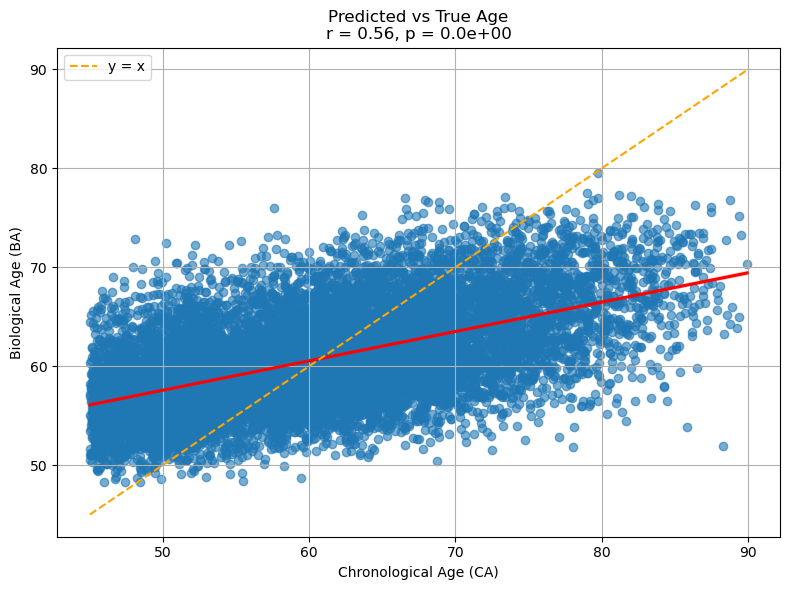

In [29]:
from scipy.stats import pearsonr
import seaborn as sns

## Calculate Pearson Correlation
r, p_value = pearsonr(df_ana['true_age'], df_ana['predicted_age'])
print(f"Pearson correlation: r = {r:.4f}, p = {p_value:.4e}")

plt.figure(figsize=(8,6))
sns.regplot(
    x='true_age',
    y='predicted_age',
    data=df_ana,
    scatter_kws={'alpha':0.6},
    line_kws={'color': 'red'}
)

# 添加 y = x 的参考线
min_val = min(df_ana['true_age'].min(), df_ana['predicted_age'].min())
max_val = max(df_ana['true_age'].max(), df_ana['predicted_age'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='orange', label='y = x')

plt.xlabel('Chronological Age (CA)')
plt.ylabel('Biological Age (BA)')
plt.title(f'Predicted vs True Age\nr = {r:.2f}, p = {p_value:.1e}')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("results/BA_CA_correlation.png", dpi=300)
plt.show()

Pearson correlation: r = 0.5608, p = 0.0000e+00


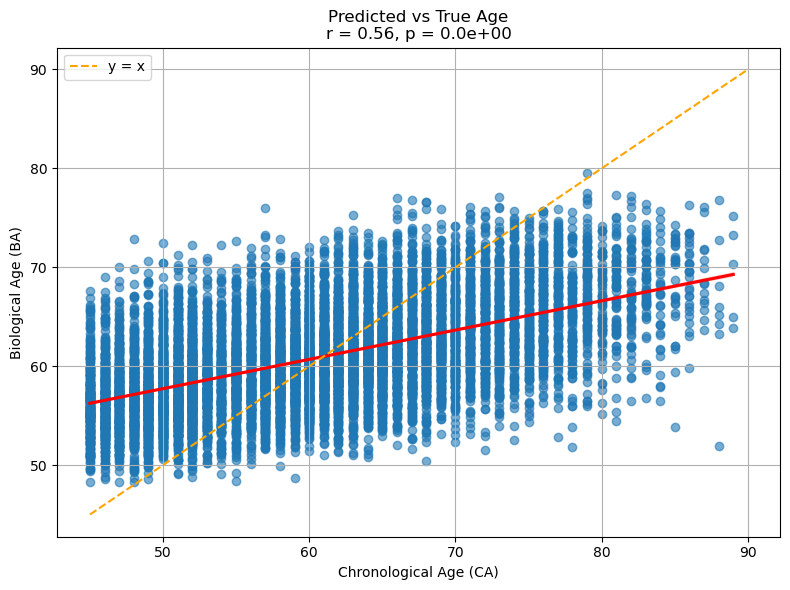

In [30]:
## Calculate Pearson Correlation
r, p_value = pearsonr(df_ana['true_age'], df_ana['predicted_age'])
print(f"Pearson correlation: r = {r:.4f}, p = {p_value:.4e}")

plt.figure(figsize=(8,6))
sns.regplot(
    x='CA_round',
    y='predicted_age',
    data=df_ana,
    scatter_kws={'alpha':0.6},
    line_kws={'color': 'red'}
)

# 添加 y = x 的参考线
min_val = min(df_ana['true_age'].min(), df_ana['predicted_age'].min())
max_val = max(df_ana['true_age'].max(), df_ana['predicted_age'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='orange', label='y = x')

plt.xlabel('Chronological Age (CA)')
plt.ylabel('Biological Age (BA)')
plt.title(f'Predicted vs True Age\nr = {r:.2f}, p = {p_value:.1e}')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig("results/BAA_CA_correlation.png", dpi=300)
plt.show()

#### Correlation between BA and CA by Gender

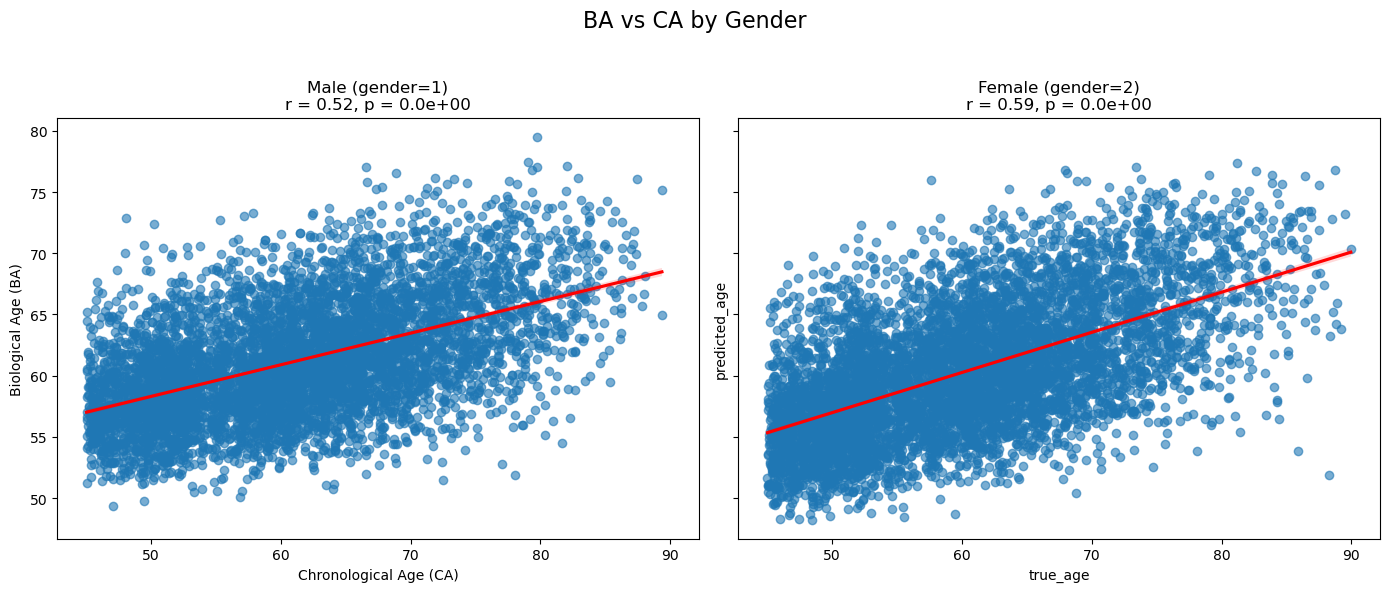

In [31]:
df_male = df_ana[df_ana['Gender'] == 1].copy()
df_female = df_ana[df_ana['Gender'] == 2].copy()

# Pearson correlation
r_m, p_m = pearsonr(df_male['true_age'], df_male['predicted_age'])
r_f, p_f = pearsonr(df_female['true_age'], df_female['predicted_age'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Male plots
sns.regplot(data=df_male, x='true_age', y='predicted_age',
            scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'}, ax=axes[0])
axes[0].set_title(f"Male (gender=1)\nr = {r_m:.2f}, p = {p_m:.1e}")
axes[0].set_xlabel("Chronological Age (CA)")
axes[0].set_ylabel("Biological Age (BA)")

# Female plots
sns.regplot(data=df_female, x='true_age', y='predicted_age',
            scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'}, ax=axes[1])
axes[1].set_title(f"Female (gender=2)\nr = {r_f:.2f}, p = {p_f:.1e}")
axes[0].set_xlabel("Chronological Age (CA)")
axes[0].set_ylabel("Biological Age (BA)")

# General setting
plt.suptitle("BA vs CA by Gender", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save pictures
plt.savefig("results/age_prediction_by_gender.png", dpi=300)
plt.show()

### Correlation (BAA & CA)

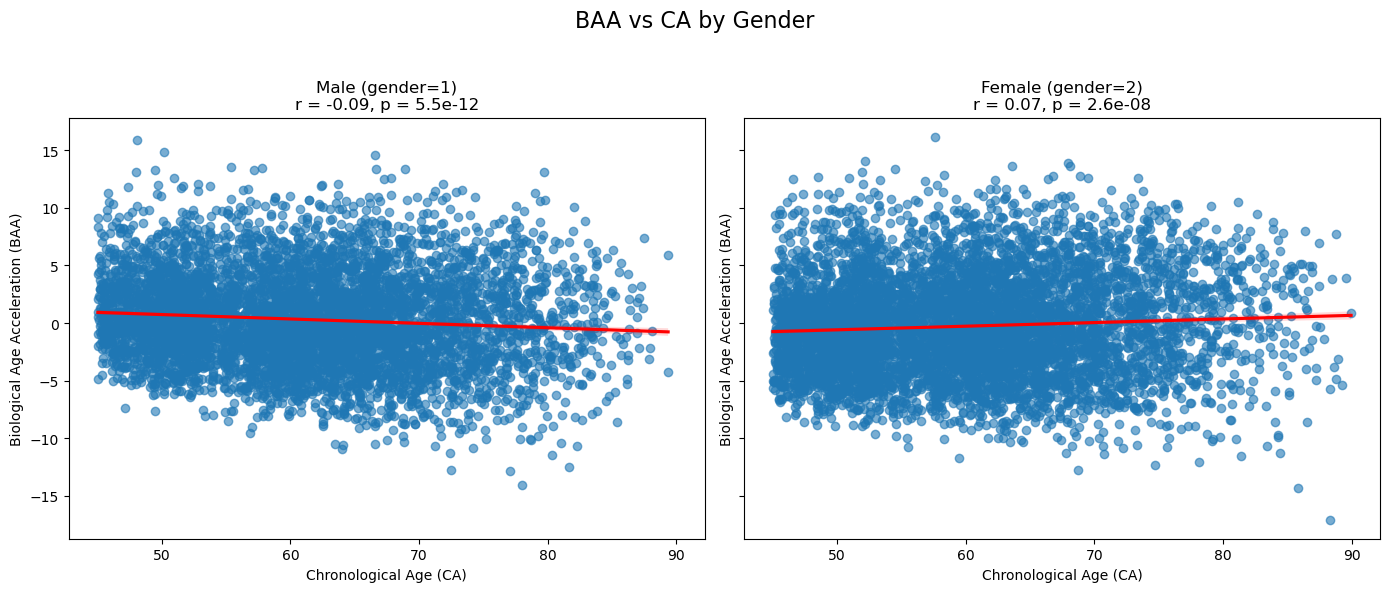

In [32]:
df_male = df_ana[df_ana['Gender'] == 1].copy()
df_female = df_ana[df_ana['Gender'] == 2].copy()

# Pearson correlation
r_m, p_m = pearsonr(df_male['true_age'], df_male['BAA'])
r_f, p_f = pearsonr(df_female['true_age'], df_female['BAA'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Male plots
sns.regplot(data=df_male, x='true_age', y='BAA',
            scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'}, ax=axes[0])
axes[0].set_title(f"Male (gender=1)\nr = {r_m:.2f}, p = {p_m:.1e}")
axes[0].set_xlabel("Chronological Age (CA)")
axes[0].set_ylabel("Biological Age Acceleration (BAA)")

# Female plots
sns.regplot(data=df_female, x='true_age', y='BAA',
            scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'}, ax=axes[1])
axes[1].set_title(f"Female (gender=2)\nr = {r_f:.2f}, p = {p_f:.1e}")
axes[1].set_xlabel("Chronological Age (CA)")
axes[1].set_ylabel("Biological Age Acceleration (BAA)")

# General setting
plt.suptitle("BAA vs CA by Gender", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save pictures
plt.savefig("results/CA_BAA_by_gender.png", dpi=300)
plt.show()

### Associations with Health Outcomes

#### BA and Death

In [33]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import statsmodels.api as sm

# Outcome
y = df_ana['death']

# Model 1: gender + BA
X1 = sm.add_constant(df_ana[['Gender', 'BA']])
model1 = sm.Logit(y, X1).fit()
pred1 = model1.predict(X1)
auc1 = roc_auc_score(y, pred1)

# Model 2: gender + CA
X2 = sm.add_constant(df_ana[['Gender', 'CA']])
model2 = sm.Logit(y, X2).fit()
pred2 = model2.predict(X2)
auc2 = roc_auc_score(y, pred2)

# Model 3: gender + BA + CA
X3 = sm.add_constant(df_ana[['Gender', 'BA', 'CA']])
model3 = sm.Logit(y, X3).fit()
pred3 = model3.predict(X3)
auc3 = roc_auc_score(y, pred3)

# Summary Table with AUC
summary_df = pd.DataFrame({
    'Model': ['gender + BA', 'gender + CA', 'gender + BA + CA'],
    'AIC': [model1.aic, model2.aic, model3.aic],
    'BIC': [model1.bic, model2.bic, model3.bic],
    'Pseudo_R2': [model1.prsquared, model2.prsquared, model3.prsquared],
    'AUC': [auc1, auc2, auc3]
})

print(summary_df)

with open("results/model1_summary(death).txt", "w") as f:
    f.write(model1.summary().as_text())

with open("results/model2_summary(death).txt", "w") as f:
    f.write(model2.summary().as_text())

with open("results/model3_summary(death).txt", "w") as f:
    f.write(model3.summary().as_text())

Optimization terminated successfully.
         Current function value: 0.147340
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.140707
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.139919
         Iterations 8
              Model          AIC          BIC  Pseudo_R2       AUC
0       gender + BA  3613.188142  3635.425781   0.072421  0.715349
1       gender + CA  3450.776755  3473.014394   0.114185  0.771384
2  gender + BA + CA  3433.505269  3463.155454   0.119140  0.775879


#### BAA and Death

In [34]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import statsmodels.api as sm

# Outcome
y = df_ana['death']

# Model 1: gender + BA
X1 = sm.add_constant(df_ana[['Gender', 'BAA']])
model1 = sm.Logit(y, X1).fit()
pred1 = model1.predict(X1)
auc1 = roc_auc_score(y, pred1)

# Model 2: gender + CA
X2 = sm.add_constant(df_ana[['Gender', 'CA']])
model2 = sm.Logit(y, X2).fit()
pred2 = model2.predict(X2)
auc2 = roc_auc_score(y, pred2)

# Model 3: gender + BA + CA
X3 = sm.add_constant(df_ana[['Gender', 'BAA', 'CA']])
model3 = sm.Logit(y, X3).fit()
pred3 = model3.predict(X3)
auc3 = roc_auc_score(y, pred3)

# Summary Table with AUC
summary_df = pd.DataFrame({
    'Model': ['gender + BAA', 'gender + CA', 'gender + BAA + CA'],
    'AIC': [model1.aic, model2.aic, model3.aic],
    'BIC': [model1.bic, model2.bic, model3.bic],
    'Pseudo_R2': [model1.prsquared, model2.prsquared, model3.prsquared],
    'AUC': [auc1, auc2, auc3]
})

print(summary_df)

with open("results/model1_summary(BAA_death).txt", "w") as f:
    f.write(model1.summary().as_text())

with open("results/model2_summary(BAA_death).txt", "w") as f:
    f.write(model2.summary().as_text())

with open("results/model3_summary(BAA_death).txt", "w") as f:
    f.write(model3.summary().as_text())

Optimization terminated successfully.
         Current function value: 0.154940
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.140707
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.139919
         Iterations 8
               Model          AIC          BIC  Pseudo_R2       AUC
0       gender + BAA  3799.240304  3821.477943   0.024578  0.630168
1        gender + CA  3450.776755  3473.014394   0.114185  0.771384
2  gender + BAA + CA  3433.505273  3463.155458   0.119140  0.775879


#### BA and Stroke

In [35]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import statsmodels.api as sm

# Outcome
y = df_ana['stroke']

# Model 1: gender + BA
X1 = sm.add_constant(df_ana[['Gender', 'BAA']])
model1 = sm.Logit(y, X1).fit()
pred1 = model1.predict(X1)
auc1 = roc_auc_score(y, pred1)

# Model 2: gender + CA
X2 = sm.add_constant(df_ana[['Gender', 'CA']])
model2 = sm.Logit(y, X2).fit()
pred2 = model2.predict(X2)
auc2 = roc_auc_score(y, pred2)

# Model 3: gender + BA + CA
X3 = sm.add_constant(df_ana[['Gender', 'BAA', 'CA']])
model3 = sm.Logit(y, X3).fit()
pred3 = model3.predict(X3)
auc3 = roc_auc_score(y, pred3)

# Summary Table with AUC
summary_df = pd.DataFrame({
    'Model': ['gender + BA', 'gender + CA', 'gender + BA + CA'],
    'AIC': [model1.aic, model2.aic, model3.aic],
    'BIC': [model1.bic, model2.bic, model3.bic],
    'Pseudo_R2': [model1.prsquared, model2.prsquared, model3.prsquared],
    'AUC': [auc1, auc2, auc3]
})

print(summary_df)

with open("results/model1_summary(stroke).txt", "w") as f:
    f.write(model1.summary().as_text())

with open("results/model2_summary(stroke).txt", "w") as f:
    f.write(model2.summary().as_text())

with open("results/model3_summary(stroke).txt", "w") as f:
    f.write(model3.summary().as_text())

Optimization terminated successfully.
         Current function value: 0.023553
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023550
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023531
         Iterations 10
              Model         AIC         BIC  Pseudo_R2       AUC
0       gender + BA  582.619893  604.857532   0.011176  0.603263
1       gender + CA  582.541021  604.778660   0.011311  0.610812
2  gender + BA + CA  584.079391  613.729576   0.012103  0.626048


#### BAA and Stroke

In [36]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import statsmodels.api as sm

# Outcome
y = df_ana['stroke']

# Model 1: gender + BA
X1 = sm.add_constant(df_ana[['Gender', 'BAA']])
model1 = sm.Logit(y, X1).fit()
pred1 = model1.predict(X1)
auc1 = roc_auc_score(y, pred1)

# Model 2: gender + CA
X2 = sm.add_constant(df_ana[['Gender', 'CA']])
model2 = sm.Logit(y, X2).fit()
pred2 = model2.predict(X2)
auc2 = roc_auc_score(y, pred2)

# Model 3: gender + BA + CA
X3 = sm.add_constant(df_ana[['Gender', 'BAA', 'CA']])
model3 = sm.Logit(y, X3).fit()
pred3 = model3.predict(X3)
auc3 = roc_auc_score(y, pred3)

# Summary Table with AUC
summary_df = pd.DataFrame({
    'Model': ['gender + BAA', 'gender + CA', 'gender + BAA + CA'],
    'AIC': [model1.aic, model2.aic, model3.aic],
    'BIC': [model1.bic, model2.bic, model3.bic],
    'Pseudo_R2': [model1.prsquared, model2.prsquared, model3.prsquared],
    'AUC': [auc1, auc2, auc3]
})

print(summary_df)

with open("results/model1_summary(BAA_stroke).txt", "w") as f:
    f.write(model1.summary().as_text())

with open("results/model2_summary(BAA_stroke).txt", "w") as f:
    f.write(model2.summary().as_text())

with open("results/model3_summary(BAA_stroke).txt", "w") as f:
    f.write(model3.summary().as_text())

Optimization terminated successfully.
         Current function value: 0.023553
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023550
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023531
         Iterations 10
               Model         AIC         BIC  Pseudo_R2       AUC
0       gender + BAA  582.619893  604.857532   0.011176  0.603263
1        gender + CA  582.541021  604.778660   0.011311  0.610812
2  gender + BAA + CA  584.079391  613.729576   0.012103  0.626048


## Save model and scaler functions

In [40]:
import joblib
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# retrain model on the full data set
# scaler = StandardScaler()
# X_scaled = pd.DataFrame(
#     scaler.fit_transform(df_x),
#     columns=df_x.columns,
#     index=df_x.index
# ) # For XGboost, we don't need to scalar

model = xgb.XGBRegressor(n_estimators=800, learning_rate=0.05, max_depth=5, random_state=123)
model.fit(df_biomarker, df_y)

# Save model and scaler
joblib.dump(model, 'trained_models/ba_xgboost_model.pkl')
joblib.dump(md_lr_BA_CA, 'trained_models/LR_adjust_ba_ca.pkl')

# Save predicted BA and round CA
predicted_ba = model.predict(df_biomarker)
age_group = np.floor(df_y).astype(int)

df_ba_dist = pd.DataFrame({
    'true_age': df_y,
    'age_group': age_group,
    'predicted_ba': predicted_ba
})

df_ba_dist['BAA'] = md_lr_BA_CA.predict(df_ba_dist[['true_age']])-predicted_ba

df_ba_dist.to_csv("results/df_ba_distribution.csv", index=False)

In [41]:
importance_results(model)

,Feature Name,Feature Importance
16,Weight,0.143159
18,Gender,0.113163
15,Waist,0.091384
8,Creatinine,0.086180
3,Glycated_Hemoglobin,0.073289
13,MCV,0.052918
11,BUN,0.049507
2,Hemoglobin,0.046299
4,CRP,0.038640
10,Triglycerides,0.037625
